In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import gc
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import sklearn
from sklearn.cluster import KMeans
import rasterio
from rasterio.mask import mask

from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
from numpy import int16, int32

In [2]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_{service_type}_tiles.zip"
    return url

def get_scree_plot(X, nclusters = 10, random_state = 42):
    gc.collect()
    wcss = [] 
    for i in range(1, nclusters + 1): 
        print(i, 'Started')
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = random_state)
        kmeans.fit(X) 
        wcss.append(kmeans.inertia_)
        print(i, 'Completed')
        
    return wcss

def make_scree_plot(wcss):
    fig, ax = plt.subplots(figsize = (5, 5))
    ax.plot(np.arange(1, len(wcss)+1), wcss, color='black', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    plt.ylabel('Within cluster sum of squares')
    plt.xlabel('No. of clusters')
    sns.despine()
    plt.show()
    
def run_kmeans(n_clusters, random_state = 42):
    kmeans = KMeans(n_clusters = n_clusters, init = "k-means++", random_state = random_state)
    return kmeans


In [3]:
#### Read mobile data
tile_url = get_tile_url("mobile", 2019, 1)
display(tile_url)  
df_mobile = gpd.read_file(tile_url)

'https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dmobile/year%3D2019/quarter%3D1/2019-01-01_performance_mobile_tiles.zip'

#### India

In [13]:
#### Read GADM data


df_gadm = gpd.read_file("/data/tmp/snair/IndiaBoundary.shp")

In [17]:
#### Subset to India Tiles Only
gc.collect()
df_gadm = df_gadm.to_crs("EPSG:4326")
df_india = gpd.sjoin(df_gadm, df_mobile,  how="inner")
print(df_india.shape)
ids_to_keep = df_india.quadkey.unique()
df_india = df_mobile[df_mobile.quadkey.isin(ids_to_keep)]
print(df_india.shape)
gc.collect()

(372548, 9)
(372357, 7)


408

In [18]:
df_india.corr()

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
avg_d_kbps,1.000000,0.421675,-0.178918,-0.036437,-0.031757
avg_u_kbps,0.421675,1.000000,-0.155825,-0.016444,-0.021007
avg_lat_ms,-0.178918,-0.155825,1.000000,-0.045621,-0.057808
tests,-0.036437,-0.016444,-0.045621,1.000000,0.912110
devices,-0.031757,-0.021007,-0.057808,0.912110,1.000000


1 Started
1 Completed
2 Started
2 Completed
3 Started
3 Completed
4 Started
4 Completed
5 Started
5 Completed
6 Started
6 Completed
7 Started
7 Completed
8 Started
8 Completed
9 Started
9 Completed
10 Started
10 Completed


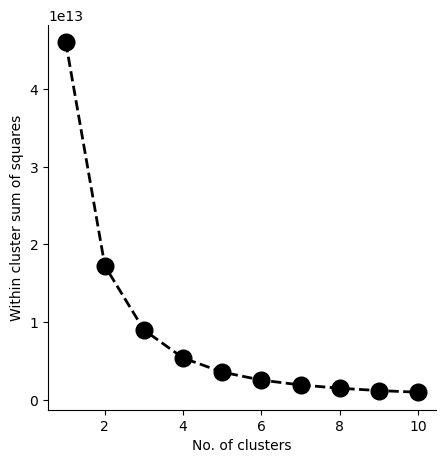

In [20]:
## Select features
kmeans_cols = ['avg_d_kbps', 'tests']

df_kmeans = df_india.copy()
X = df_kmeans[kmeans_cols].values

wcss = get_scree_plot(X)
make_scree_plot(wcss)

In [21]:
### based on scree plot, elbow is at 
kmeans = run_kmeans(n_clusters = 5)
y_kmeans = kmeans.fit_predict(X)

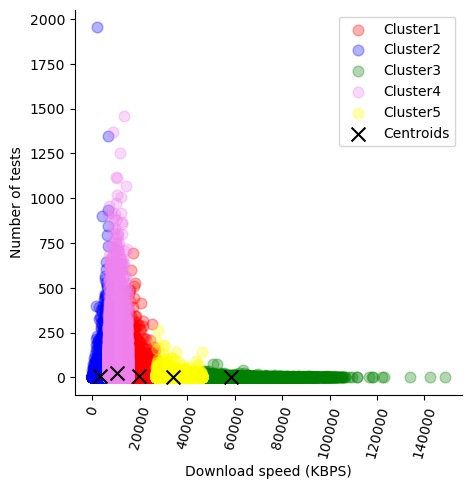

In [26]:
fig, ax = plt.subplots(figsize = (5, 5))
plt.scatter( X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 60, c = 'red', label = 'Cluster1', alpha = 0.3)
plt.scatter( X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 60, c = 'blue', label = 'Cluster2',  alpha = 0.3)
plt.scatter( X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 60, c = 'green', label = 'Cluster3',  alpha = 0.3) 
plt.scatter( X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 60, c = 'violet', label = 'Cluster4',  alpha = 0.3) 
plt.scatter( X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 60, c = 'yellow', label = 'Cluster5',  alpha = 0.3)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids', marker = 'x')
plt.xlabel('Download speed (KBPS)') 
plt.ylabel('Number of tests') 
plt.legend() 

#https://www.speedtest.net/global-index

plt.xticks(rotation = 75)
sns.despine()
plt.show()


In [24]:
df_kmeans['cluster'] = y_kmeans
df_kmeans['cluster_color'] = df_kmeans['cluster'].map({0:'red', 1:'blue', 2:'green', 3:'violet', 4:'yellow'})

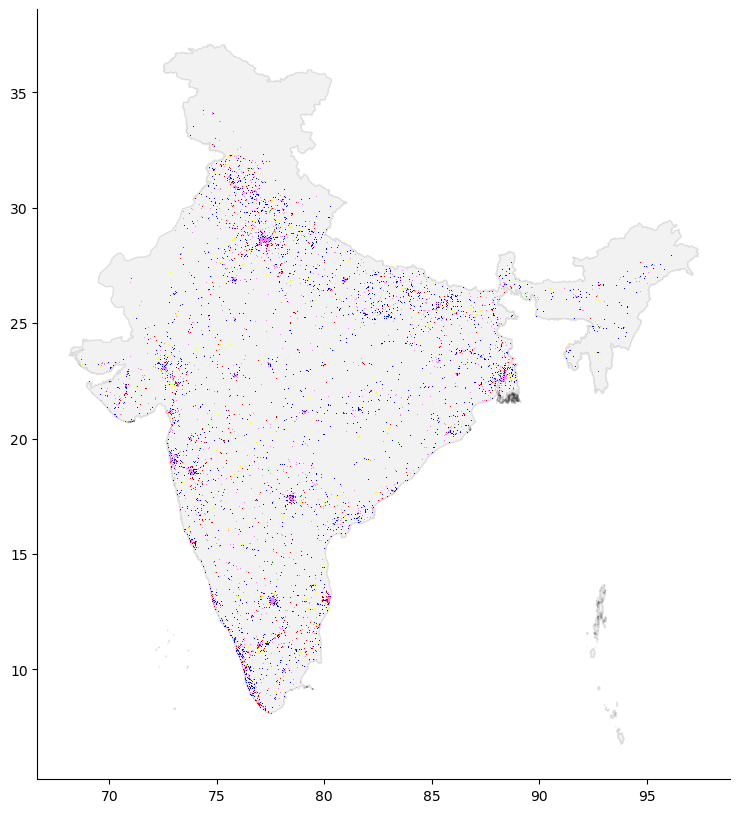

In [32]:
fig, ax = plt.subplots(figsize = (10, 10))
df_gadm.plot(ax = ax, facecolor = 'grey', alpha = 0.1, edgecolor= 'black')
df_kmeans.plot(color = df_kmeans['cluster_color'], ax = ax)
sns.despine()
plt.show()

#### Peru

In [28]:
#####
df_gadm1 = gpd.read_file("/data/climate_migration/shp/gadm36_0.shp")
df_gadm1 = df_gadm1[df_gadm1.NAME_0 == 'Peru']

In [29]:
#### Subset to Peru Tiles Only
gc.collect()
df_gadm1 = df_gadm1.to_crs("EPSG:4326")
df_peru = gpd.sjoin(df_gadm1, df_mobile,  how="inner")
print(df_peru.shape)
ids_to_keep = df_peru.quadkey.unique()
df_peru = df_mobile[df_mobile.quadkey.isin(ids_to_keep)]
print(df_peru.shape)
gc.collect()

(8674, 10)
(8674, 7)


4

In [30]:
df_peru.corr()

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
avg_d_kbps,1.000000,0.635972,-0.167641,0.056175,0.104198
avg_u_kbps,0.635972,1.000000,-0.187660,0.083994,0.140554
avg_lat_ms,-0.167641,-0.187660,1.000000,-0.050718,-0.086313
tests,0.056175,0.083994,-0.050718,1.000000,0.784907
devices,0.104198,0.140554,-0.086313,0.784907,1.000000


1 Started
1 Completed
2 Started
2 Completed
3 Started
3 Completed
4 Started
4 Completed
5 Started
5 Completed
6 Started
6 Completed
7 Started
7 Completed
8 Started
8 Completed
9 Started
9 Completed
10 Started
10 Completed


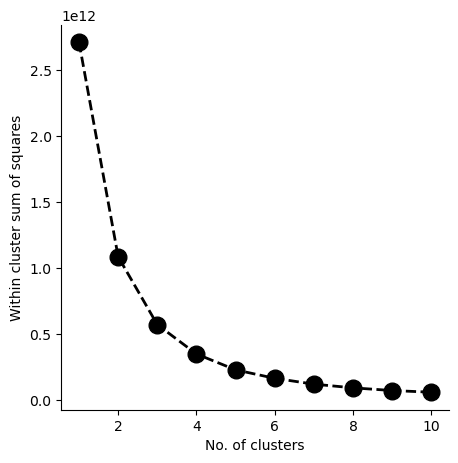

In [31]:
## Select features
kmeans_cols = ['avg_d_kbps', 'tests']

df_kmeans1 = df_peru.copy()
X = df_kmeans1[kmeans_cols].values

wcss = get_scree_plot(X)
make_scree_plot(wcss)

In [34]:
### based on scree plot, elbow is at 
kmeans = run_kmeans(n_clusters = 4)
y_kmeans = kmeans.fit_predict(X)

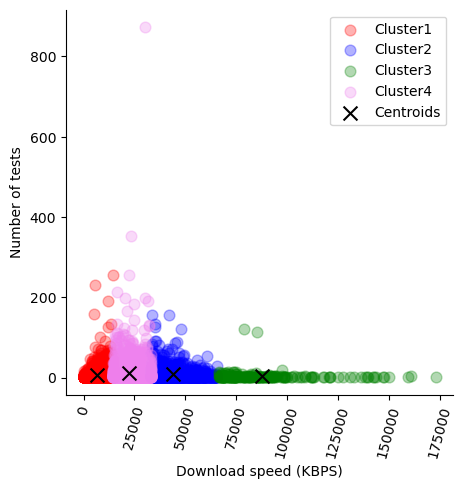

In [37]:
fig, ax = plt.subplots(figsize = (5, 5))
plt.scatter( X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 60, c = 'red', label = 'Cluster1', alpha = 0.3)
plt.scatter( X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 60, c = 'blue', label = 'Cluster2',  alpha = 0.3)
plt.scatter( X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 60, c = 'green', label = 'Cluster3',  alpha = 0.3) 
plt.scatter( X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 60, c = 'violet', label = 'Cluster4',  alpha = 0.3) 
# plt.scatter( X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 60, c = 'yellow', label = 'Cluster5',  alpha = 0.3)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids', marker = 'x')
plt.xlabel('Download speed (KBPS)') 
plt.ylabel('Number of tests') 
plt.legend() 

#https://www.speedtest.net/global-index

plt.xticks(rotation = 75)
sns.despine()
plt.show()


In [35]:
df_kmeans1['cluster'] = y_kmeans
df_kmeans1['cluster_color'] = df_kmeans1['cluster'].map({0:'red', 1:'blue', 2:'green', 3:'violet', 4:'yellow'})

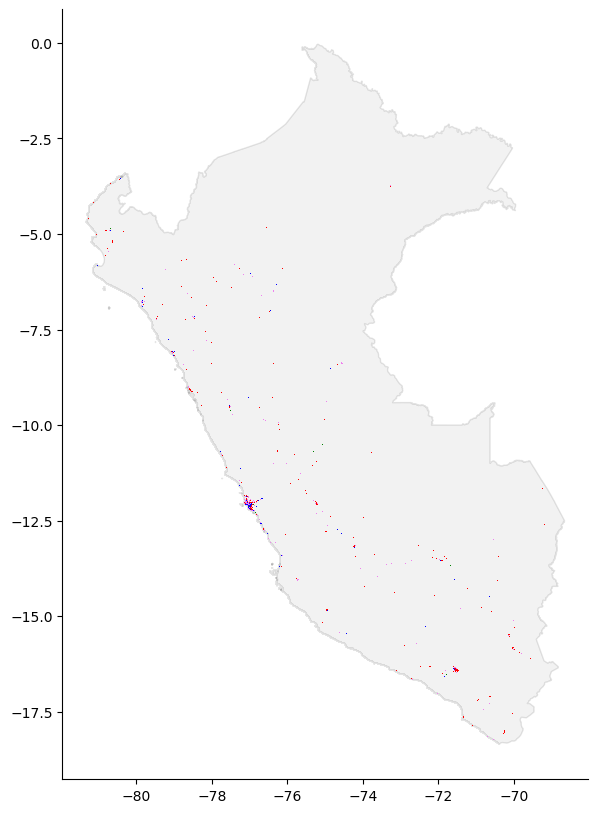

In [36]:
fig, ax = plt.subplots(figsize = (10, 10))
df_gadm1.plot(ax = ax, facecolor = 'grey', alpha = 0.1, edgecolor= 'black')
df_kmeans1.plot(color = df_kmeans1['cluster_color'], ax = ax)
sns.despine()
plt.show()